In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re


In [2]:
pd.set_option('display.max_rows', None)

In [111]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import r2_score, accuracy_score, confusion_matrix, classification_report, f1_score

In [177]:
from sklearn.model_selection import StratifiedShuffleSplit as strat_shuf_split

In [6]:
from sklearn.svm import LinearSVC

In [46]:
time = pd.read_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\Final Capstone Project\\rio dataframes\\Outside Data\\raw\\bairros\\timeserie_energia_economia_extended.csv')

#  Cleaning

### TIME

In [49]:
time.dropna(how='all', inplace=True, axis=1)

In [50]:
for col in time.columns[2:]: time[col] = time[col].fillna(time[col].mean())

In [51]:
keep = []

for i in time.Bairros:
    
    if len(i.split())>2:    
        
        if i.split()[2]=='planejamento': keep.append(False)
        else: keep.append(True)
            
    else: 
        if i=='total': keep.append(False)
        else: keep.append(True)

In [52]:
time = time[keep]

## Feature Selection

#### Note: Remember to Fill missing values with means of same neighborhood

In [53]:
targets = ['Consumo de energia elétrica (MWh)', 'Residencial_x',        # Energy related variables
       'Industrial_x', 'Comercial', 'Rural_x', 'Poder público ',
       'Iluminacão pública', 'Serv.público_x', 'Consumo próprio_x',
       'Consumo resdencial de energia elétrica (MWh)',
       'Médio anual por unidade consumidora  ',
       'Total de unidades consumidoras  residenciais ', 'Total_y.1',
       'Residencial_y', 'Industrial_y', 'Comercial ', 'Rural_y',
       'Poderes públicos ', 'Iluminação pública', 'Serv.público_y',
       'Consumo próprio_y']

In [466]:
i=-1

In [468]:
i+=1
target = targets[i]
print(i, target)

1 Residencial_x


## X & Y:

In [633]:
x = time.drop(targets, axis=1).iloc[:, 2:]

In [635]:
y = time[[target]]

### Dropping Missing Vlaues

In [642]:
var = pd.concat([pd.DataFrame(x), y], axis=1)

var.dropna(subset=['Residencial_x'], inplace=True)

In [646]:
x = var.iloc[:, :-1].reset_index(drop=True)

y = var.iloc[:, [-1]].reset_index(drop=True)

## Feature Encoding

#### Choosing Intervals for Categories

In [673]:
bins = [y[target].min()-1, 17000, 67000, 102000, 176000, 250000, y[target].max()+1]
labels=[0.,1.,2.,3.,4.,5.]

In [676]:
y_cat = pd.cut(y[target], bins, right=True, labels=labels)

y_cat.unique()

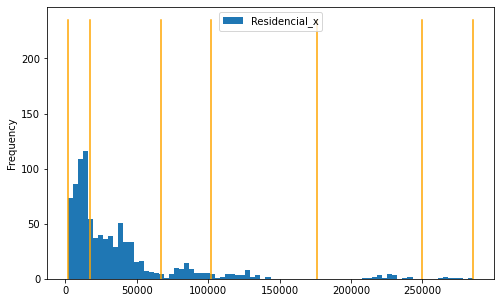

In [680]:
fig = plt.figure()
ax0 = fig.add_subplot(111)

y.plot(kind='hist', bins=80, figsize=(8,5), ax=ax0)
u = np.linspace(0,235,100)
[ax0.plot(u*0+bins[i], u, color='orange') for i in range(len(bins))]
plt.show()

#### Optional: Encoding with OrdinalEncoder

In [473]:
from sklearn.preprocessing import OrdinalEncoder

In [532]:
y_cod = OrdinalEncoder().fit_transform(y_cat.to_frame())

In [535]:
y_cod = pd.Series(y_cod.ravel())


### Encoding Testing

In [678]:
y_grp = pd.concat([y, y_cat], axis=1)

y_grp.columns=['Residencial_x', 'category']

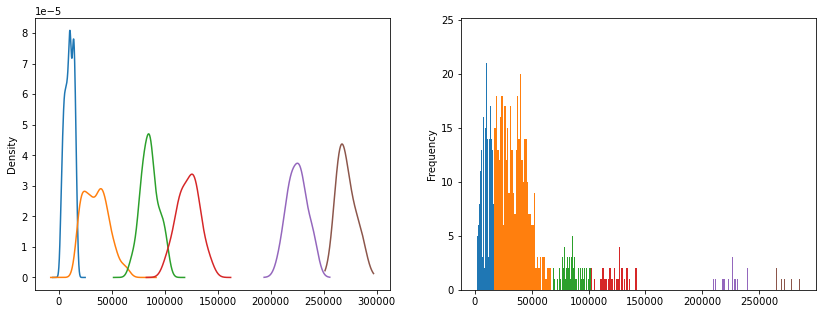

In [695]:
fig = plt.figure(figsize=(14,5))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

for i in labels:
#for i in range(5):
    
    #print((y_grp[y_grp['category']==i]['Residencial_x'].mean()))
    y_grp[y_grp['category']==i]['Residencial_x'].plot(kind='kde', ax=ax0)
    y_grp[y_grp['category']==i]['Residencial_x'].plot(kind='hist', ax=ax1, bins=40)

# Pair Plot

In [550]:
pair_df = x.iloc[:, :27].copy()

In [551]:
pair_df['Category'] = y_cat

sns.pairplot(pair_df, hue='Category')

# Log Transformation

In [650]:
x = x.apply(np.log1p)

In [ ]:
#sns.distplot(x[2017], kde=False, bins=80)

# Normalization

In [653]:
scaler = MinMaxScaler()
x_norm = scaler.fit_transform(x)

In [624]:
#scaler = StandardScaler()
#x_norm = scaler.fit_transform(x)

# Random Stratified Train Test Split

In [696]:
sss = strat_shuf_split(n_splits=1, test_size=0.25, random_state=None)
for train, test in sss.split(x_norm, y_cat):
    x_train = x_norm[train]
    x_test = x_norm[test]
    y_train = y_cat[train]
    y_test = y_cat[test]
print(y_train.value_counts(), y_test.value_counts())

0.0    305
1.0    285
2.0     50
3.0     26
4.0     13
5.0      5
Name: Residencial_x, dtype: int64 0.0    102
1.0     95
2.0     16
3.0      8
4.0      5
5.0      2
Name: Residencial_x, dtype: int64


# Modeling: Linear Support Vector Machine Classifier

### Optimizing C

In [705]:
scrs = []
for i in range(20, 60):
    
    linear_svc = LinearSVC(max_iter=1e5, C=i/10).fit(x_train, y_train)
    
    y_pred = linear_svc.predict(x_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    scrs.append([i/10, acc, f1])
    if i in range(0, 100, 5): print(i, 'attempts')
    
scrs_df = pd.DataFrame(scrs, columns=['C', 'acc', 'f1'])

scrs_df.set_index('C').plot(figsize=(8,5))
#plt.xticks(np.linspace(1/10, 51/10, 26))
plt.grid()

#### C between 0.7 and 2.1

###  Optimizing Tolerance

In [ ]:
scrs = []
for i in range(1, 100000, 1000):
    
    linear_svc = LinearSVC(max_iter=1e4, dual=True, C=1.5, tol=i/1e6).fit(x_train, y_train)
    
    y_pred = linear_svc.predict(x_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    scrs.append([i/1e6, acc, f1])
    if i in range(1, 10000, 1000): print(i, 'attempts')
    
scrs_df = pd.DataFrame(scrs, columns=['Tolerance', 'acc', 'f1'])

scrs_df.set_index('Tolerance').plot(figsize=(7,5))
#plt.xticks(np.linspace(1/10, 51/10, 51))
plt.grid()

#### Tolerance = 1e-4

### Optimal Model Evaluation

In [737]:
sss = strat_shuf_split(n_splits=1, test_size=0.25, random_state=None)
for train, test in sss.split(x_norm, y_cat):
    x_train = x_norm[train]
    x_test = x_norm[test]
    y_train = y_cat[train]
    y_test = y_cat[test]

linear_svc = LinearSVC(max_iter=1e5, C=4.5).fit(x_train, y_train)

y_pred = linear_svc.predict(x_test)

#sns.heatmap(linear_svc.coef_)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(classification_report(y_test, y_pred))
print('acc:', round(acc,6), 'f1:', round(f1,6))

              precision    recall  f1-score   support

         0.0       0.91      0.96      0.93       102
         1.0       0.90      0.84      0.87        95
         2.0       0.79      0.88      0.83        17
         3.0       0.75      0.38      0.50         8
         4.0       0.67      1.00      0.80         4
         5.0       1.00      1.00      1.00         2

    accuracy                           0.89       228
   macro avg       0.84      0.84      0.82       228
weighted avg       0.89      0.89      0.88       228

acc: 0.885965 f1: 0.882348


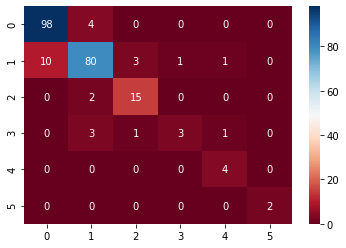

In [738]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='RdBu')